In [1]:
!pip install pandas numpy matplotlib seaborn folium gdown

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from branca.colormap import linear

sns.set(style="whitegrid")


In [4]:
# Example path — replace with your file name
df = pd.read_csv('/content/delhiaqi.csv')

# If using file id from shared Drive link (example only):
# !gdown --id <file_id> -O delhi_aqi.csv
# df = pd.read_csv("delhi_aqi.csv")

df.head()


,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83
1,2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66
2,2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40
3,2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55
4,2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19


In [6]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).reset_index(drop=True)

# Convert pollutant columns (adjust names if needed)
for col in ['pm2_5','pm10']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values (forward fill as simple approach)
df[['pm2_5','pm10']] = df[['pm2_5','pm10']].fillna(method='ffill')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    561 non-null    datetime64[ns]
 1   co      561 non-null    float64       
 2   no      561 non-null    float64       
 3   no2     561 non-null    float64       
 4   o3      561 non-null    float64       
 5   so2     561 non-null    float64       
 6   pm2_5   561 non-null    float64       
 7   pm10    561 non-null    float64       
 8   nh3     561 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 39.6 KB


/tmp/ipython-input-3839042598.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['pm2_5','pm10']] = df[['pm2_5','pm10']].fillna(method='ffill')


In [8]:
# Breakpoints (US EPA). Replace with CPCB if asked.
pm25_breakpoints = [
    (0.0, 12.0, 0, 50),
    (12.1, 35.4, 51, 100),
    (35.5, 55.4, 101, 150),
    (55.5, 150.4, 151, 200),
    (150.5, 250.4, 201, 300),
    (250.5, 350.4, 301, 400),
    (350.5, 500.4, 401, 500)
]

pm10_breakpoints = [
    (0,54,0,50),
    (55,154,51,100),
    (155,254,101,150),
    (255,354,151,200),
    (355,424,201,300),
    (425,504,301,400),
    (505,604,401,500)
]

def calc_subindex(conc, breakpoints):
    if np.isnan(conc): return np.nan
    for (B_lo, B_hi, I_lo, I_hi) in breakpoints:
        if B_lo <= conc <= B_hi:
            return ((I_hi - I_lo)/(B_hi - B_lo))*(conc - B_lo) + I_lo
    return 500.0  # if above range

df['aqi_pm25'] = df['pm2_5'].apply(lambda x: calc_subindex(x, pm25_breakpoints))
df['aqi_pm10'] = df['pm10'].apply(lambda x: calc_subindex(x, pm10_breakpoints))

# Overall AQI = max of subindices
df['AQI'] = df[['aqi_pm25','aqi_pm10']].max(axis=1)

df[['date','pm2_5','aqi_pm25','pm10','aqi_pm10','AQI']].head()

,date,pm2_5,aqi_pm25,pm10,aqi_pm10,AQI
0,2023-01-01 00:00:00,169.29,219.620721,194.64,120.619798,219.620721
1,2023-01-01 01:00:00,182.84,233.048649,211.08,128.756768,233.048649
2,2023-01-01 02:00:00,220.25,270.121622,260.68,153.811313,270.121622
3,2023-01-01 03:00:00,252.90,303.378378,304.12,175.311919,303.378378
4,2023-01-01 04:00:00,266.36,316.717117,322.80,184.557576,316.717117


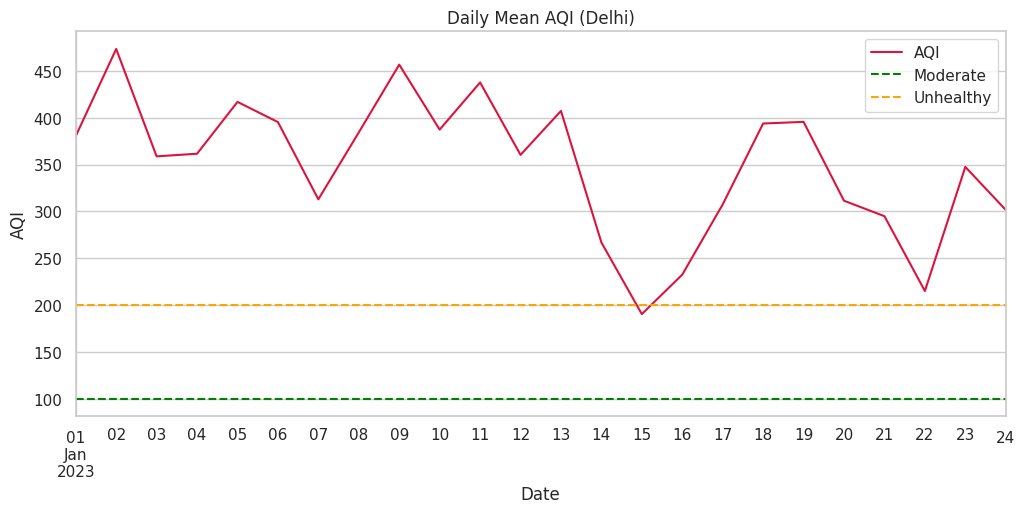

In [10]:
# Daily average AQI
daily = df.set_index('date').resample('D')['AQI'].mean().dropna()

plt.figure(figsize=(12,5))
daily.plot(color="crimson")
plt.title("Daily Mean AQI (Delhi)")
plt.ylabel("AQI")
plt.xlabel("Date")
plt.axhline(100, color='green', linestyle='--', label="Moderate")
plt.axhline(200, color='orange', linestyle='--', label="Unhealthy")
plt.legend()
plt.show()

/tmp/ipython-input-936027990.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='AQI', data=df, palette="Set2")


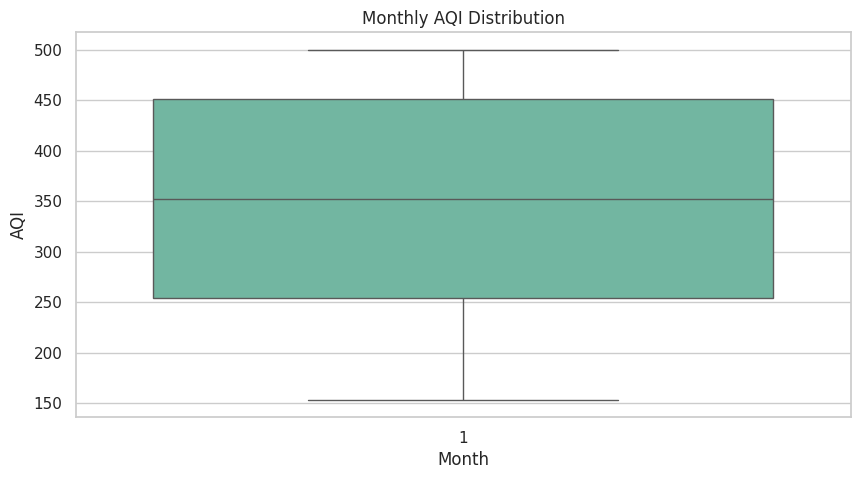

In [12]:
df['month'] = df['date'].dt.month
plt.figure(figsize=(10,5))
sns.boxplot(x='month', y='AQI', data=df, palette="Set2")
plt.title("Monthly AQI Distribution")
plt.xlabel("Month")
plt.ylabel("AQI")
plt.show()

/tmp/ipython-input-4020587282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dominant', data=df, palette="pastel")


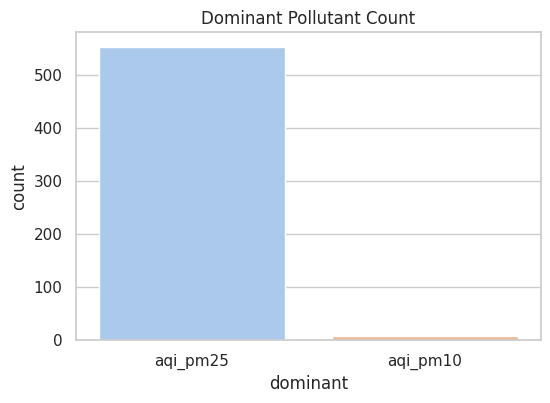

In [13]:
df['dominant'] = df[['aqi_pm25','aqi_pm10']].idxmax(axis=1)
plt.figure(figsize=(6,4))
sns.countplot(x='dominant', data=df, palette="pastel")
plt.title("Dominant Pollutant Count")
plt.show()


In [15]:
# Example if dataset has 'station','lat','lon'
if all(col in df.columns for col in ['lat','lon','station']):
    m = folium.Map(location=[28.6, 77.2], zoom_start=10)
    sample = df.dropna(subset=['lat','lon','AQI']).groupby(['station','lat','lon'])['AQI'].mean().reset_index()
    colormap = linear.YlOrRd_09.scale(sample['AQI'].min(), sample['AQI'].max())
    for _, row in sample.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=6,
            color=colormap(row['AQI']),
            fill=True, fill_opacity=0.7,
            popup=f"{row['station']}: AQI {row['AQI']:.0f}"
        ).add_to(m)
    colormap.add_to(m)
    m


### AQI Categories (EPA standard)
- 0–50: Good (Green)
- 51–100: Moderate (Yellow)
- 101–150: Unhealthy for Sensitive Groups (Orange)
- 151–200: Unhealthy (Red)
- 201–300: Very Unhealthy (Purple)
- 301–500: Hazardous (Maroon)


In a text cell at the bottom, write:

Which months had worst AQI (see boxplot).

Which pollutant dominated (see dominant count).

Daily trend (see time-series).

Public health insight (AQI often exceeds 200 → unhealthy).